# Writing and designing Jupyter notebooks

Writing a good quality Jupyter notebook is challenging and there is no perfect solution.  But one thing is clear you should aim to organise and write-up the work following what you believe to be a clear scientific style. Document your aims, methods, experiments, results and conclusions.  This notebook provides some guidance and examples.  But it is not a panacea for all studies. Be create and find a structure that works for your particular study. 

> Don't be afraid to re-write and re-structure notebooks if you think it needs improvement. But if you do I advise making a copy first and also testing all code still runs afterwards.

## Imports

### Standard imports

In [1]:
import numpy as np
import time as time

# to help with numpy type hints
import numpy.typing as npt

from typing import Optional

# ignore the meta-py deprecation warnings.
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

### Non-standard imports

The package `meta-py` (available on PyPI `pip install meta-py`) was used in our sample methods section to provide input data

In [2]:
from metapy import __version__
from metapy.tsp import tsp_io as io
from metapy.tsp.euclidean import gen_matrix, plot_tour
from metapy.local_search.hill_climbing import TweakTwoOpt, SimpleTweak
from metapy.tsp.objective import OptimisedSimpleTSPObjective

print(__version__)

0.4.0


## Constants

In [3]:
URL_ST70 = "https://raw.githubusercontent.com/TomMonks" + "/meta-py/main/data/st70.tsp"

## An overview of sections in a experimental report

There are no hard and fast rules for a Jupyter notebook structure that contains computational models and experiments. However, from general experimental science we know that the following standard format works well (adapted from Field and Hole, 2003).

* Title
* Abstract and/or plain English summary
* Introduction
* Method
    * Analysis environment
    * Design
    * Models/Algorithms
    * Case studies
    * Procedure
* Results
* Discussion
* References
* Appendix (e.g. testing of code/models; potentially links to a separate notebook)

Field and Hole (2003) state that the above structure is relevant for experimental research as it answers the following four questions:

1. **Why** did the authors run the experiments with their models and what did they aim to find? This may include a simple list of research questions or objectives. (**introduction**)
2. **How** was the experimental work carried out?  What models were used, how were they implemented (e.g. a 3rd party library or implemented directly); what experimental design was used? (**methods**) 
3. **What** were the **results** of the experiments?  Ideally clearly presented so that they are simple for others to understand.
4. **So What?** What do the results means, what are the strengths and limitations of the study. What further work could be completed? 

# An example methods section

In this simple example, a general optimisation algorithm called GRASP is implemented.  It is applied to a famous combinatorial optimisation problem - the **Travelling salesman problem (TSP)**.

The image below illustrates a "good" solution to an instance of the TSP called st70.  It depicts a series of cities located in a 2D grid that a salesman must visit once and only once.  A complete circuit of all cities (with return to origin) is called a tour.

<img src="images/tsp_image.png" alt="Drawing" style="width: 500px;"/>

> Assume the methods section follows `1. Introduction` that descibes the background and objectives of the study reported in the notebook.

## 2. Methods

In this study we will use a basic form of the GRASP metaheuristic algorithm to solve the symmetric Travelling Salesman Problem (TSP). In the TSP a salesman must visit a set of cities once and only once in the shortest possible distance (or time).  The Greedy Randomised Adaptive Search Procedure (**GRASP**) was introduced by Rio and Resende in 1989. It is an extremely simple multi-start **metaheuristic**. The basic form of GRASP is based on two phases:

1. an initial semi-greedy construction/repair phase; 
2. a period of local search to improve on the initial solution.

The basic GRASP algorithm is outlined below.  Note that the TSP implementation of GRASP in this study always results in feasible solutions.  Optionally GRASP may include a **repair** function used to modify infeasible solutions created during the construction phase.

```
PROCEDURE basic_grasp():
    
    best = []
    do 
    
        s = greedy_construction()
        s = local_search(s)

        if cost(s) > cost(best):
            best = s
    
    until max iterations or time limit reached.
    
    return best
```

### 2.1 Data

We use the st70 dataset (70 cities in a symmetric TSP problem that uses euclidean distance). This data was sourced from [TSPLib](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/). For this notebook the data has been stored online and can be converted to a cost matrix using the following `load_st70` function.

In [4]:
def load_st70(file_path: Optional[str] = URL_ST70) -> tuple[npt.NDArray, npt.NDArray]:
    """
    Load the st70 TSP dataset as matrix of euclidean distances between cities.
    Returns a list of city coordinates and a cost matrix (distances)

    Parameters:
    ----------
    file_path: str
        Path or URL to st70 datafile.

    Returns:
    -------
    Tuple[np.ndarray, np.ndarray]
    i.e. cities, matrix
    """
    # number of rows in the st70 file that contain meta_data
    md_rows = 6

    # read the coordinates
    cities = io.read_coordinates(file_path, md_rows)

    # generate euclidean distance matrix
    matrix = gen_matrix(cities, as_integer=True)

    return cities, matrix

### 2.2 Representing and visualising a tour

In our approach a tour is simply an ordered vector of integers. Each integer represents a unique city index in the cost matrix.

For example to create a staring tour for the st70 problem.

In [5]:
# create ordered list of cities to visit
tour = np.arange(70)
# peak at first 10 elements
tour[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

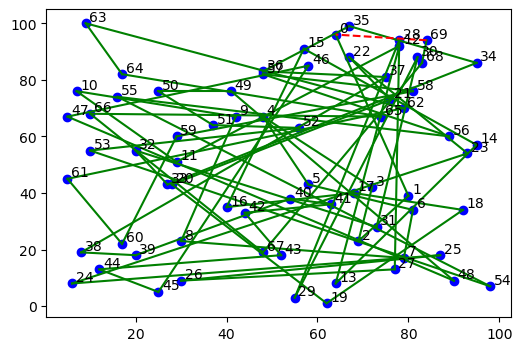

In [6]:
cities, matrix = load_st70()
_ = plot_tour(tour, cities)

### 2.3 Components of GRASP

#### 2.3.1 Restricted Candidate Lists

The first step in semi-greedy construction is to create the restricted candidate list: the list of top valued components that the algorithm will choose from in its next step. In the TSP a straightforward implementation is choosing the closest r cities where r is a hyper-parameter that can be fixed, a random variable or learned over time.

Below we implement the fixed sized 

In [7]:
class FixedRCLSizer:
    """
    Fixed sized Restricted candidate list for use with GRASP algorithm

    When r = 1 then the algorithm is 100% greedy
    WhenL r = len(tour) then becomes a random search
    """

    def __init__(self, r: int) -> None:
        """
        Initialiser for FixedRCLSizer

        Parameters:
        ----------
        r: int
            The size of the candidate list. Assumes r is a postive integer > 0
        """
        self.r = r

    def get_size(self) -> int:
        """
        Returns an int representing the size of the required RCL

        Returns:
        --------
        int
        """
        return self.r

#### 2.3.2 Semi-greedy construction

A fundamental part of GRASP is semi-greedy construction.  In a purely **greedy construction** method for the TSP we select a starting point in the tour and then choose the next closest city (the nearest neighbour algorithm). We continue to do this until all cities are visited. In contrast in **Semi-Greedy construction** we modify the approach to incorporate the probability. Instead of always visiting the closest city there is now a probability that we visit one of the n closest cities.  Therefore semi-greedy algorithms are a half way house between random and greedy search.

We now introduce a basic semi-greedy implementation in Python.

A key point to remember is that construction is iterative. A new RCL is created in each iteration and a city is chosen from it at random until all cities have been added to the tour.

Here we create a `SemiGreedyConstructor` class. The class accepts a rcl_sizer as an argument (an object that implements a `get_size()` method). This means you can vary the RCL sizing logic and treat it as a hyper parameter.

In [8]:
class SemiGreedyConstructor:
    """
    Semi-greedy construction of a tour.

    For a city i the constructor creates a restricted candidate list of size r
    i.e the r cities within the shortest distances of city i.
    The next city in the tour is chosen with equal probability.
    This process repeats until a full tour is constructed.
    """

    def __init__(
        self,
        rcl_sizer: object,
        tour: npt.NDArray[int],
        matrix: npt.NDArray,
        random_seed: Optional[int] = None,
    ) -> None:
        """
        Constructor method

        Parameters:
        ------
        rcl_sizer: object
            sizes the restricted candidate list. Assumes object implements
            the get_size() method

        tour: np.ndarray
            vector of city indexes included in problem

        matrix: np.ndarray
            matrix of travel costs. This could be distances or travel times.

        random_seed: int
            used to control random sampling and provide a reproducible result.
        """

        # size of rcl
        self.rcl_sizer = rcl_sizer

        # cities in a tour
        self.tour = tour

        # travel cost matrix
        self.matrix = matrix

        # create random number generator
        self.rng = np.random.default_rng(random_seed)

    def build(self):
        """
        Semi-greedy contruction of tour of
        n cities.

        Returns an ordered vector where each element is index of a city.

        Returns:
        --------
        np.ndarray
        """
        # first city in tour
        solution = np.array([self.tour[0]])

        # it is an iterative (construction) procedure
        for i in range(len(self.tour) - 1):
            # get the RCL size
            r = self.rcl_sizer.get_size()

            # get the RCL
            rcl = self.get_rcl(r, solution, solution[-1])

            # select the next city
            next_city = self.random_from_rcl(rcl)

            # update the solution
            solution = np.append(solution, np.array([next_city]))

        return solution

    def get_rcl(
        self, r: int, solution: npt.NDArray[int], from_city: int
    ) -> npt.NDArray:
        """
        Restricted candidate list for final city in current solution

        Parameters:
        -------
        r: int
            Size of the retricted candidate list

        solution: np.ndarray
            vector of current partially constructed solution

        from_city: int
            index of city used to construct rcl.

        Returns:
        -------
        np.ndarray
        """
        # get indexes of cities not in solution
        mask = self.tour[~np.in1d(self.tour, solution)]

        # get indexes of r smallest travels costs
        if mask.shape[0] > r:
            # partition the vector for remaining cities - faster than sorting
            idx = np.argpartition(self.matrix[from_city][mask], len(mask) - r)[-r:]
            rcl = mask[idx]
        else:
            # handle when r < n cities remaining
            rcl = mask
        return rcl

    def random_from_rcl(self, rcl: npt.NDArray[int]) -> int:
        """
        Select a city at random from a restricted candidate list.
        Return the city index to select.

        Parameters:
        -------
        rcl: np.ndarray
            restricted candidate list vector of candidate city indexes.

        Returns:
        --------
        int: index of city to select
        """
        return self.rng.choice(rcl)

#### 2.3.3 Local search

Here we implement a simple hill climbing local search algorithm.

In [9]:
class HillClimber:
    """
    A simple first improvement hill climbing algorithm
    """

    def __init__(
        self, objective, init_solution, tweaker, maximisation=True, time_limit=None
    ):
        """
        Constructor

        Parameters:
        ------
        objective: object
            optimisation target

        init_solution: np.ndarray
            numpy representation of solution

        tweaker: object
            tweak operation for hill climber

        maximisation: bool, optional (default=True)
            Is this a max or min optimisation?

        time_limit: float, optional (default=None)
            If set to float hill climbing termates when time limit is reached.
        """
        self._objective = objective

        if maximisation:
            self._negate = 1.0
        else:
            self._negate = -1.0

        self.set_init_solution(init_solution)
        self._tweaker = tweaker

        # hill climbing time limit
        if time_limit is None:
            self._time_limit = np.inf
        else:
            self._time_limit = time_limit

    def set_init_solution(self, solution):
        self.solution = solution
        self.best_solutions = [solution]
        self.best_cost = self._objective.evaluate(solution) * self._negate

    def solve(self):
        """
        Run first improvement hill climbing

        Returns:
        --------
        None
        """
        improvement = True
        start = time.time()

        while improvement and ((time.time() - start) < self._time_limit):
            improvement = False

            for city1 in range(1, len(self.solution) - 1):
                # print("city1: {0}".format(city1))
                for city2 in range(city1 + 1, len(self.solution) - 1):
                    # print("city2: {0}".format(city2))

                    self._tweaker.tweak(
                        tour=self.solution, start_index=city1, end_index=city2
                    )

                    neighbour_cost = (
                        self._objective.evaluate(self.solution) * self._negate
                    )

                    if neighbour_cost > self.best_cost:
                        self.best_cost = neighbour_cost
                        self.best_solutions = [self.solution]
                        improvement = True
                    else:
                        self._tweaker.tweak(self.solution, city1, city2)

### 2.4 The main GRASP algorithm

The main algorithm for a GRASP has been implemented in a class `GRASP`. The class accepts the following parameters:

* Logic for the semi-greedy constructor.
* The local search algorithm.
* Parameters that control the run duration.


Once setup the algorithm is run using the `solve` method.  Attributes `best` and `best_solution` contain the lowest cost and matching tour found respectively.

In [10]:
class GRASP:
    """
    Greedy Randomised Adaptive Search Procedure algorithm
    for the Travelling Salesman Problem.

    Attributes:
    -----------
    best: float
        the best (lowest) cost solution found.

    best_solution: np.ndarray
        the best tour found
    """

    def __init__(
        self,
        constructor: SemiGreedyConstructor,
        local_search: HillClimber,
        max_iter: Optional[int] = 1000,
        time_limit: Optional[float] = np.inf,
    ) -> None:
        """
        Constructor

        Parameters:
        ---------
        constructor: object
            semi-greedy construction heuristic

        local_search: object
            local search heuristic e.g. `HillClimber`

        max_iter: int, optional (default=1000)
            The maximum number of iterations (restarts) of GRASP

        time_limit: float64, optional (default=np.inf)
            The maximum allowable run time.

        """
        # semi greedy tour construction method
        self.constructor = constructor

        # local search procedure
        self.local_search = local_search

        # max runtime budget for GRASP
        self.max_iter = max_iter
        self.time_limit = time_limit

        # init solution
        self.best_solution = None
        self.best = None

    def solve(self) -> None:
        """
        Run GRASP against the specified TSP problem.

        Returns:
        -------
        None
        """
        self.best_solution = None
        self.best = -np.inf

        i = 0
        start = time.time()

        while i < self.max_iter and ((time.time() - start) < self.time_limit):

            i += 1

            # construction phase
            solution = self.constructor.build()

            # Improve solution via local search
            self.local_search.set_init_solution(solution)
            self.local_search.solve()

            current_solution = self.local_search.best_solutions[0]
            current = self.local_search.best_cost

            # check if better than current solution
            if current > self.best:
                self.best = current
                self.best_solution = current_solution

### 2.5 A function to parameterise basic GRASP

The function `get_grasp` a recipe to bring together the GRASP ingredients into a the full executable algorithm.

In [11]:
def get_grasp(
    tour: npt.NDArray[int],
    matrix: npt.NDArray,
    max_iter: Optional[int] = 50,
    rcl_size: Optional[int] = 5,
    random_seed: Optional[int] = None,
) -> GRASP:
    """
    Parameterises and returns a basic GRASP model

    To reduce code in this notebook the function
    makes use of local search functionality in the meta-py package.

    Parameters:
    ------
    tour: np.array
        cities in tour as vector

    matrix: np.array
        matrix of costs

    max_iter: int, optional (default=50)
        The number of iterations (restarts) of GRASP

    rcl_size: int optional (default=5)
        if int then a FixedRCLSizer is used.

    random_seed: int, optional (default=None)
        control the sampling of the semi-greedy constructor

    Returns:
    -------
    An instance of the GRASP algorithm ready to be run.

    """
    # objective function; optimised = numpy
    obj = OptimisedSimpleTSPObjective(-matrix)

    # Two-opt tweaks
    tweaker = TweakTwoOpt()

    # local search = first improvement hill climbing
    ls = HillClimber(obj, tour, tweaker)

    # semi-greedy constructor and RCL sizer
    sizer = FixedRCLSizer(r=rcl_size)
    constructor = SemiGreedyConstructor(sizer, tour, -matrix, random_seed)

    # bring ingredients together in the GRASP framework
    solver = GRASP(constructor, ls, max_iter=max_iter)

    return solver

### 2.6 Experiments

We include 2 experiments encapsulated in functions:

1. A fixed restricted candidate list of size 5, 20 max iterations
2. A fixed restricted candidate list of size 3, 20 max iterations

As the algorithms are stochastic (i.e. stochastic selection from a restricted candidate list). We run them each 5 times and compare the average cost.

> **Student note**: using functions for your experiments - to create objects etc. - is very useful for 2 reasons. First it helps with finding bugs due to global (or notebook scope) variables accidentally used inside your model code. Second it helps with easy repeatability of your experiments. The latter means that others can easily obtain the same results as you.

In addition to the two experiments themselves a general function called `experiment` is included. It has the following purpose:

1. Load the TSP data
2. Call `get_grasp` to parameterise the GRASP algorithm as specified
3. Run the solver.
4. Repeat the experiment n times and keep track of each result and best solution
5. Return the costs and best solution from each repeat to the calling code.

Below we first present the `experiment` function and two calling functions `experiment_1` and `experiment_2` 

In [12]:
def experiment(
    random_seed: int,
    experiment_id: str,
    replications: Optional[int] = 5,
    max_iter: Optional[int] = 50,
    rcl_size: Optional[int] = 5,
) -> tuple[list, list]:
    """
    A general function for running a TSP experiment with a GRASP object
    and problem setup multiple times.

    Parameters:
    -----------
    random_seed: int
        Seed to return reproducible results from the experiment.

    replications: int, Optional (default = 5)
        The number of repetitions of the experiment to run.

    max_iter:
    """
    print(f"EXPERIMENT {experiment_id}")
    print(f"{random_seed=}; {replications=}; {max_iter=}; {rcl_size=}")

    # create random number generator and n seeds for each run.
    rng = np.random.default_rng(random_seed)
    seeds = rng.integers(low=0, high=1_000_000, size=replications)

    costs = []
    solution_tours = []

    print("Rep: ", end=" ")
    # repeat solve n times.
    for i in range(replications):
        print(f"{i}", end="; ")

        # load the data
        cities, matrix = load_st70()

        # create a tour 0... len(cities) - 1
        tour = np.arange(len(cities))

        # parameterise grasp
        solver = get_grasp(tour, matrix, max_iter, rcl_size, seeds[i])

        # run solver...
        solver.solve()

        costs.append(solver.best)
        solution_tours.append(solver.best_solution)
    print(f"EXPERIMENT {experiment_id} COMPLETE.")

    return costs, solution_tours

In [13]:
def experiment_1(replications: Optional[int] = 5) -> tuple[list, list]:
    """
    Experiment 1
    Set RCL size to 5
    Max iterations = 20

    Parameters:
    ----------
    replications: int, Optional (default = 5)
        Number of repeats of the experiment to run.

    Returns:
    --------
    tuple containing a list of best costs and best solutions.
    """
    return experiment(
        random_seed=42,
        experiment_id="1",
        replications=replications,
        max_iter=20,
        rcl_size=5,
    )

In [14]:
def experiment_2(replications: Optional[int] = 5) -> tuple[list, list]:
    """
    Experiment 2
    Set RCL size to 3
    Max iterations = 20

    Parameters:
    ----------
    replications: int, Optional (default = 5)
        Number of repeats of the experiment to run.

    Returns:
    --------
    tuple containing a list of best costs and best solutions.
    """
    return experiment(
        random_seed=42,
        experiment_id="2",
        replications=replications,
        max_iter=20,
        rcl_size=3,
    )

# 3. Results

> To help with understanding the methods section below we show how to run the two experiments and show some of the results. In a real study some commentary, explanation and additional care with presentation would be required.

In [15]:
# run experiment 1
exp_one_costs, exp_one_solutions = experiment_1(replications=5)

# run experiment 2
exp_two_costs, exp_two_solutions = experiment_2(replications=5)

EXPERIMENT 1
random_seed=42; replications=5; max_iter=20; rcl_size=5
Rep:  0; 1; 2; 3; 4; EXPERIMENT 1 COMPLETE.
EXPERIMENT 2
random_seed=42; replications=5; max_iter=20; rcl_size=3
Rep:  0; 1; 2; 3; 4; EXPERIMENT 2 COMPLETE.


In [16]:
# average cost
print("Average costs (lower is best):")
print(f"Experiment 1 = {-np.asarray(exp_one_costs).mean()}")
print(f"Experiment 2 = {-np.asarray(exp_two_costs).mean()}")

Average costs (lower is best):
Experiment 1 = 770.2
Experiment 2 = 745.2


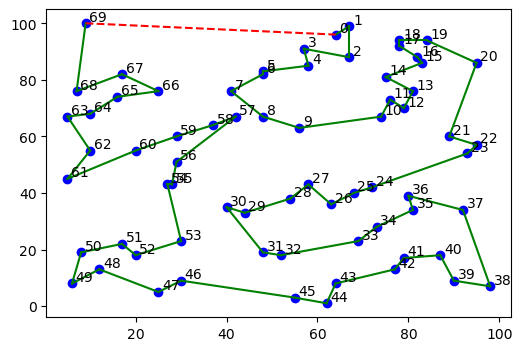

In [17]:
# plot an example tour from experiment 2
cities, matrix = load_st70()
fig, ax = plot_tour(exp_two_solutions[2], cities)

In [18]:
fig.savefig("tsp_image.png", dpi=300, bbox_inches="tight")